In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import roadrunner

# Test RoadRunner

In [2]:
r = roadrunner.RoadRunner("CS_Signalling_ERBB_RAS_AKT.xml")

In [3]:
# number of species
len(r.model.getFloatingSpeciesInitConcentrationIds())

1229

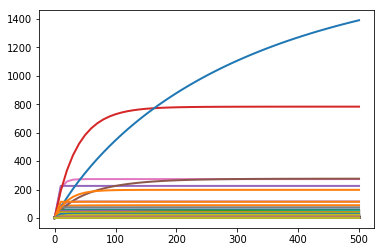

In [4]:
r.simulate(0,500);
r.plot();

# Model simulation

In [82]:
class sbmlmodel:
    
    def __init__(self, path):
        self.model = roadrunner.RoadRunner(path)
        self.path = path
        
        fixedId = []
        fixedInd = []
        flexId = []
        flexInd = []
        initId = self.model.model.getFloatingSpeciesInitConcentrationIds()
        self.initId = initId
        self.initconc = self.model.model.getFloatingSpeciesInitConcentrations()
        self.maxconc = max(self.initconc)
        self.minconc = min(self.initconc)
        # find which species have fixed initial concentrations
        for i in range(len(initId)):
            try:
                self.model.model[initId[i]] = 1
                flexId.append(initId[i])
                flexInd.append(i)
            except:
                fixedId.append(initId[i])
                fixedInd.append(i)
        self.fixedId = fixedId
        self.fixedInd = fixedInd
        self.flexId = flexId
        self.flexInd = flexInd
        
        self.reset()
        self.ss = self.model.simulate(0,10000,1000)
        
        # give a very small baseline value (1/10 of the smallest non-zero initial concentration) to zero values
        # in order to calculate perturbed/unperturbed ratio later
        self.baseline = min(self.ss[-1][1:][self.ss[-1][1:]>0])/10
    
    def reset(self):
        self.model = roadrunner.RoadRunner(self.path)
    
    def simu(self, npert=1, minpert=1, i=1, nT=100, dT=1, record=True):
        self.reset()
        if npert != 0:
            # range of perturbation/initial concentration (between 0.2-1x max concentration)
            
            #initconcs = np.random.uniform(0,2*self.maxconc,int(len(self.initId)-len(self.fixedId)))
            #initconcs = np.concatenate([np.random.uniform(-self.maxconc,-0.2*self.maxconc,len(self.initId)),
            #                            np.random.uniform(0.2*self.maxconc,self.maxconc,len(self.initId))])
            #np.random.shuffle(initconcs)
            
            # randomly choose minpert to npert species to perturb
            
            #initconcs = np.random.choice(initconcs, len(self.initId))
            initconcs = np.random.uniform(0.2*self.maxconc,10*self.maxconc,len(self.initId))
            #initconcs = np.repeat(0, len(self.initId))
            #nmask = np.random.choice(range(int(len(self.initId)-len(self.fixedId)-int(npert)),
            #                               int(len(self.initId)-len(self.fixedId)-minpert+1)),1)[0]
            nmask = np.random.choice(range(int(len(self.initId)-int(npert)),
                                           int(len(self.initId)-minpert+1)),1)[0]
            #nmask = int(len(initId)-len(fixedId)-2)
            #mask = np.random.choice(range(int(len(self.initId)-len(self.fixedId))), nmask, replace=False)
            mask = np.random.choice(range(int(len(self.initId))), nmask, replace=False)
            initconcs[mask] = 0
            #initconcs[mask] = 1
        else:
            #initconcs = self.initconc*i
            initconcs = np.repeat(0.0,len(self.initId))
        concs = initconcs + self.ss[-1][1:]
        concs[concs < 0] = 0
        #initconcs = ss[-1][1:]*initconcs
        try:
            self.model.model.setFloatingSpeciesInitConcentrations(concs)
        except: 
            for j in range(len(self.flexId)):
            #    self.model.model[self.flexId[i]] = initconcs[i]
                self.model.model[self.flexId[j]] = concs[self.flexInd[j]]
            
        result = self.model.simulate(0,int(nT*dT),nT)
        #pert = r.model.model.getFloatingSpeciesInitConcentrations()
        pert = initconcs
        if record:
            self.result = result
            self.pert = pert
        else:
            return(result[-1][1:], pert)
    
    # big batch simulation of ncond perturbation conditions
    def batch_simu(self, npert, ncond, minpert=1, seed=25, nT=100, dT=1):
        results=[]
        perts=[]
        np.random.seed(seed)
        for i in range(ncond):
            #try:
            result, pert = self.simu(npert, minpert, i, nT, dT, record=False)
            #except:
            #    result = np.repeat(np.nan, len(self.initId))
            #    pert = np.repeat(np.nan, len(self.initId))
            result[result==0] = self.baseline
            #results.append(result)
            results.append(np.log2(result/self.ss[-1][1:]))
            #results.append(result-self.ss[-1][1:])
            #results.append(np.log2((result/sum(result))/(self.ss[-1][1:]/sum(self.ss[-1][1:]))))
            perts.append(pert)
        tmp = pd.DataFrame(data=results)
        #tmp = tmp.T
        self.results = tmp
        tmp = pd.DataFrame(data=perts)
        #tmp = tmp.T
        self.perts = tmp

## choose a nice sbml model

In [83]:
# take one sbml model as an example
r = sbmlmodel("BioModels-search-results_20191212/BIOMD0000000453.xml")

In [84]:
# 109 species
len(r.initId)

109

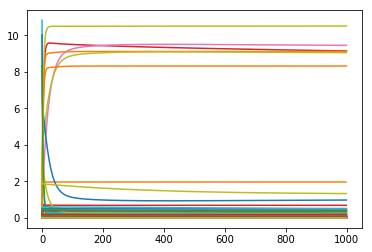

In [77]:
# randomly perturb between 1 and 10 nodes and plot results
r.simu(10, nT=1000)
plt.plot(r.result[:,1:]);

## simulate batches of perturbations

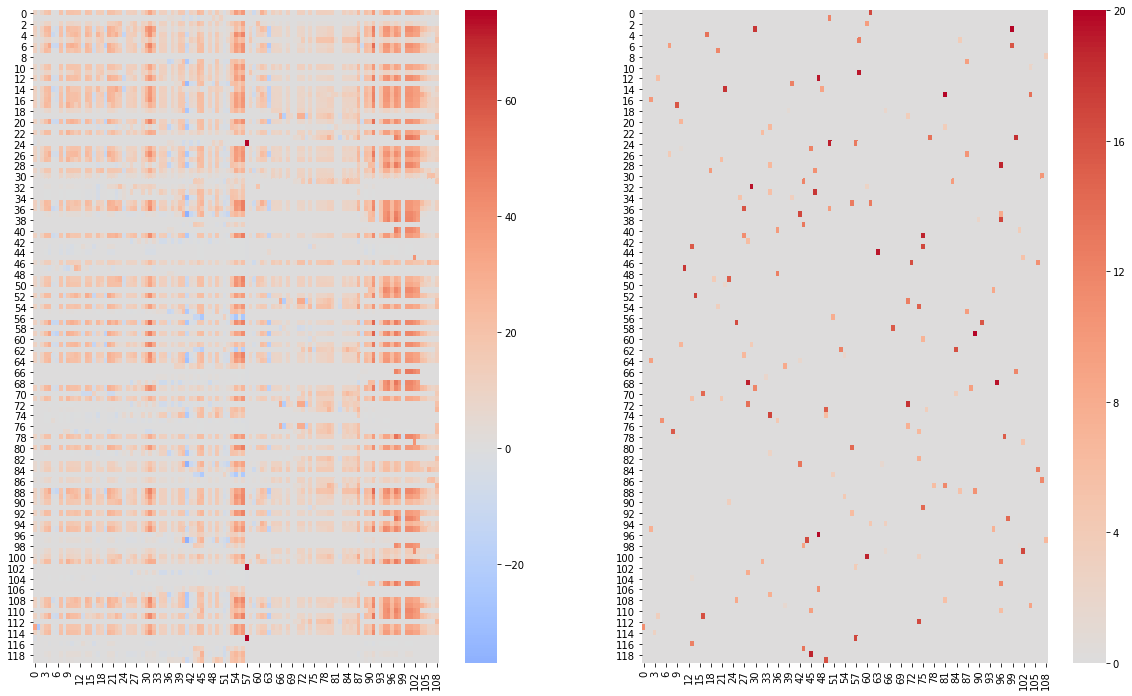

In [78]:
# single or pair-wise perturbation, 120 conditions
r.batch_simu(2, 120, minpert=1)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(20,12))
# plot end point expr, and pert
sns.heatmap(r.results, ax=ax1, cmap='coolwarm', center=0)
sns.heatmap(r.perts, ax=ax2, cmap='coolwarm', center=0)

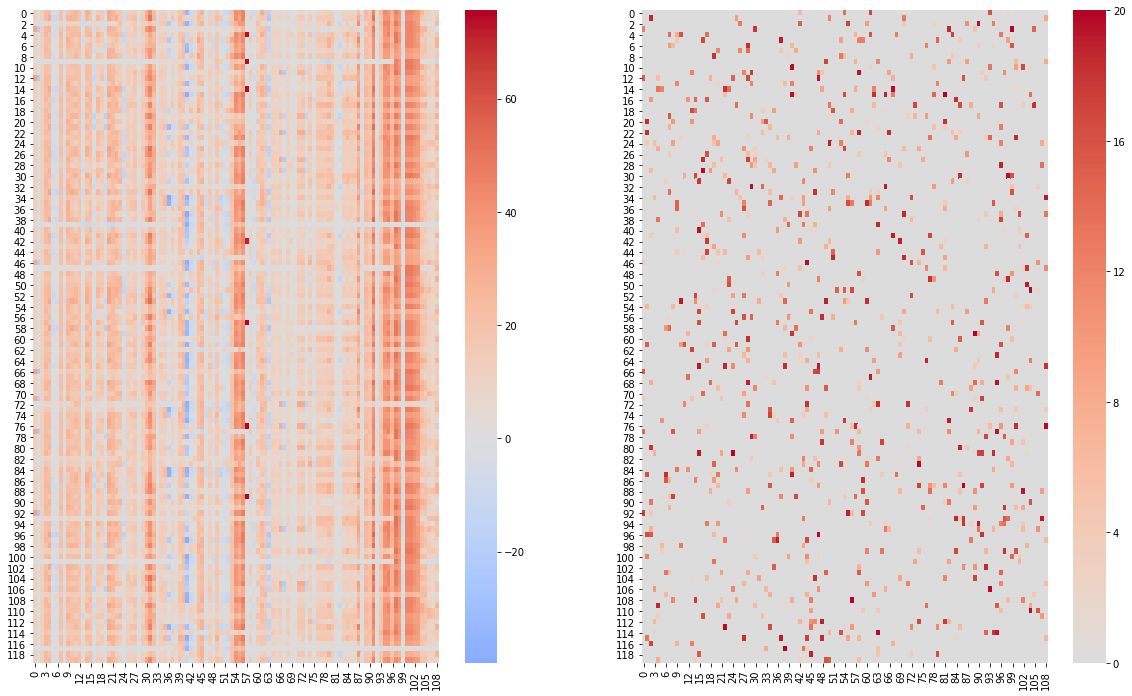

In [81]:
# multiple-node perturbation (5-10), 120 conditions
r.batch_simu(10, 120, minpert=5)
f, (ax1,ax2) = plt.subplots(1,2,figsize=(20,12))
# plot end point expr, and pert
sns.heatmap(r.results, ax=ax1, cmap='coolwarm', center=0)
sns.heatmap(r.perts, ax=ax2, cmap='coolwarm', center=0)

# Network visualization of a chosen model

In [86]:
import networkx as nx
from networkx.drawing.nx_pydot import read_dot

In [318]:
g = nx.DiGraph(read_dot("BIOMD0000000453_url.dot"))

In [319]:
# 460 total species, 109 with labels
len(list(g.nodes))

460

In [341]:
labels = {}
for x in g.nodes:
    labels[x]=g.nodes[x]['label'][1:-1]

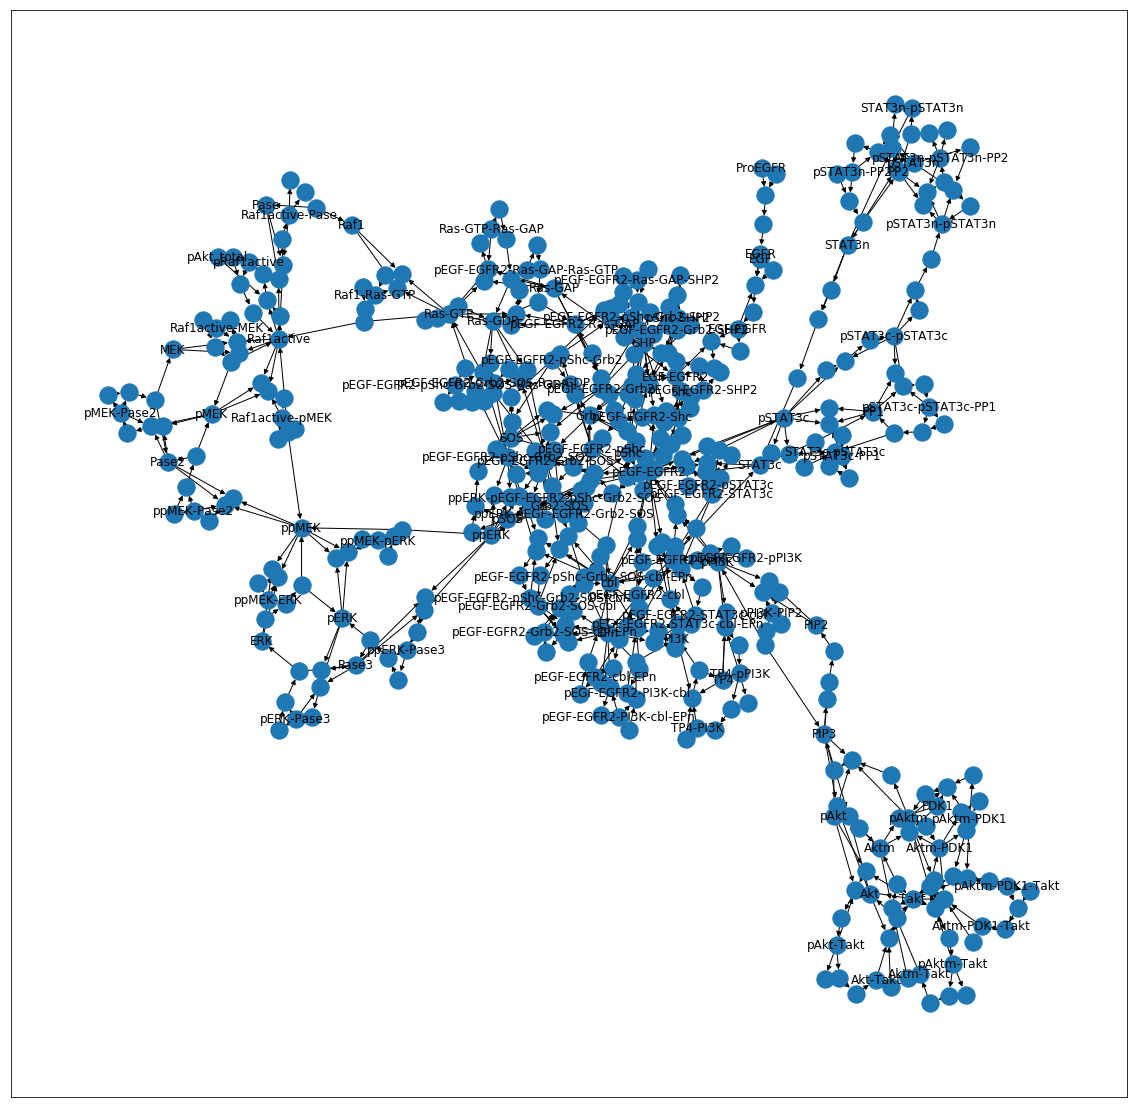

In [347]:
# plot all species with intermediate species
pos=nx.kamada_kawai_layout(g)
f, ax = plt.subplots(figsize=(20,20))
nx.draw_networkx_nodes(g,pos)
nx.draw_networkx_edges(g,pos)
#nx.draw(g, with_labels=False, font_weight='bold')
nx.draw_networkx_labels(g,pos,labels);

In [348]:
def simplifyGraph(G,n):
    ''' Loop over the graph until all intermediate nodes have been removed and their incident edges fused '''
    ''' n is the number of real nodes to be kept'''
    g = G.copy()

    while len(g.nodes)>n:
        g0 = g.copy() 
        emptnodes = [x for x in g.nodes][n:]
        for node in emptnodes:
            innodes = [x[0] for x in list(g.in_edges(node))]
            outnodes = [x[1] for x in list(g.out_edges(node))]

            for i in range(len(innodes)):
                for j in range(len(outnodes)):
                    g0.add_edge(innodes[i],outnodes[j])
            #g0.remove_edges_from(list(g0.edges(node)))
            g0.remove_node(node)
        #g0.remove_nodes_from(list(nx.isolates(g0)))
        g = g0
    return g

In [349]:
gmod = simplifyGraph(g,109)

In [352]:
labels = {}
for x in gmod.nodes:
    labels[x]=gmod.nodes[x]['label'][1:-1]

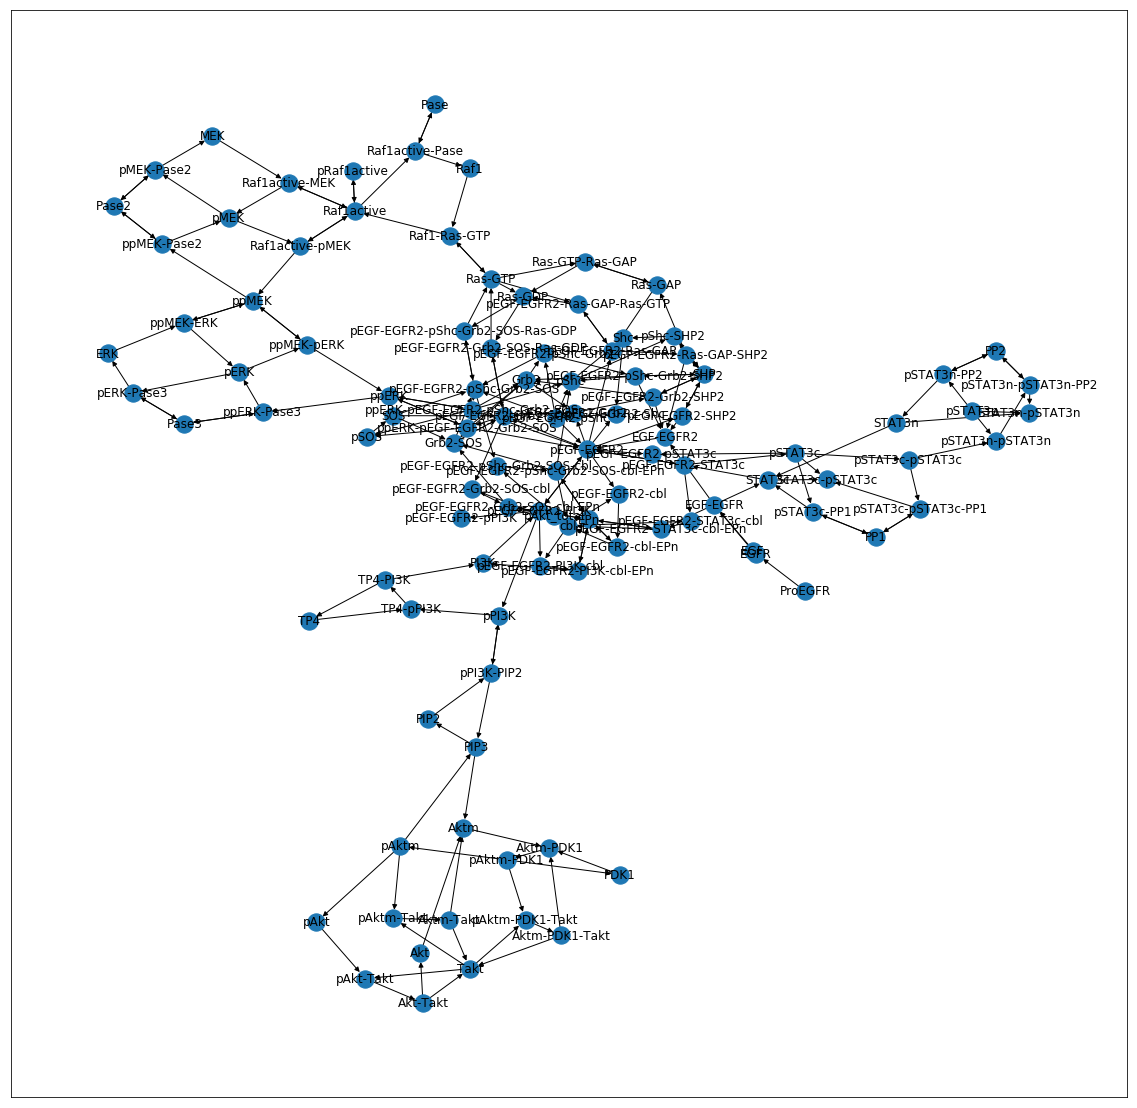

In [353]:
pos=nx.kamada_kawai_layout(gmod)
f, ax = plt.subplots(figsize=(20,20))
nx.draw_networkx_nodes(gmod,pos)
nx.draw_networkx_edges(gmod,pos)
#nx.draw(g, with_labels=False, font_weight='bold')
nx.draw_networkx_labels(gmod,pos,labels);